<a href="https://www.kaggle.com/code/mashallandme/twitter-sentiment-analysis-nlp?scriptVersionId=188865073" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Install and Import packages

In [1]:
!pip install wordcloud

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-07-18 19:02:29.645020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 19:02:29.645182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 19:02:29.834868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/twitter/twitter.csv


## Load Data

In [3]:
tweets_df = pd.read_csv('/kaggle/input/twitter/twitter.csv')

## EDA

In [4]:
tweets_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
tweets_df.shape

(31962, 3)

In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
tweets_df = tweets_df.drop('id',axis=1)

array([[<Axes: title={'center': 'label'}>]], dtype=object)

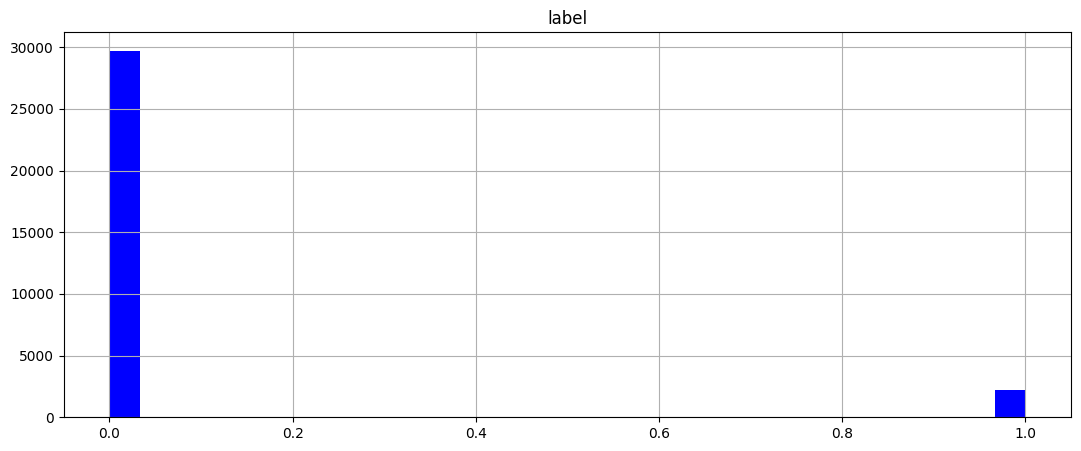

In [8]:
tweets_df.hist(bins=30, figsize=(13,5),color='b')

In [9]:
tweets_df['length']=tweets_df['tweet'].apply(len)

In [10]:
tweets_df.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


In [11]:
tweets_df.describe()

,label,length
count,31962.000000,31962.000000
mean,0.070146,84.739628
std,0.255397,29.455749
min,0.000000,11.000000
25%,0.000000,63.000000
50%,0.000000,88.000000
75%,0.000000,108.000000
max,1.000000,274.000000


<Axes: >

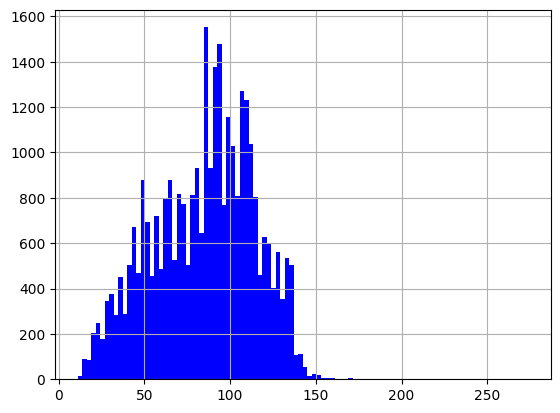

In [12]:
tweets_df['length'].hist(bins=100,color='b')

### Data Transformation

In [13]:
sentences = tweets_df['tweet'].tolist()
len(sentences)

31962

In [14]:
sentences_one_string = " ".join(sentences)

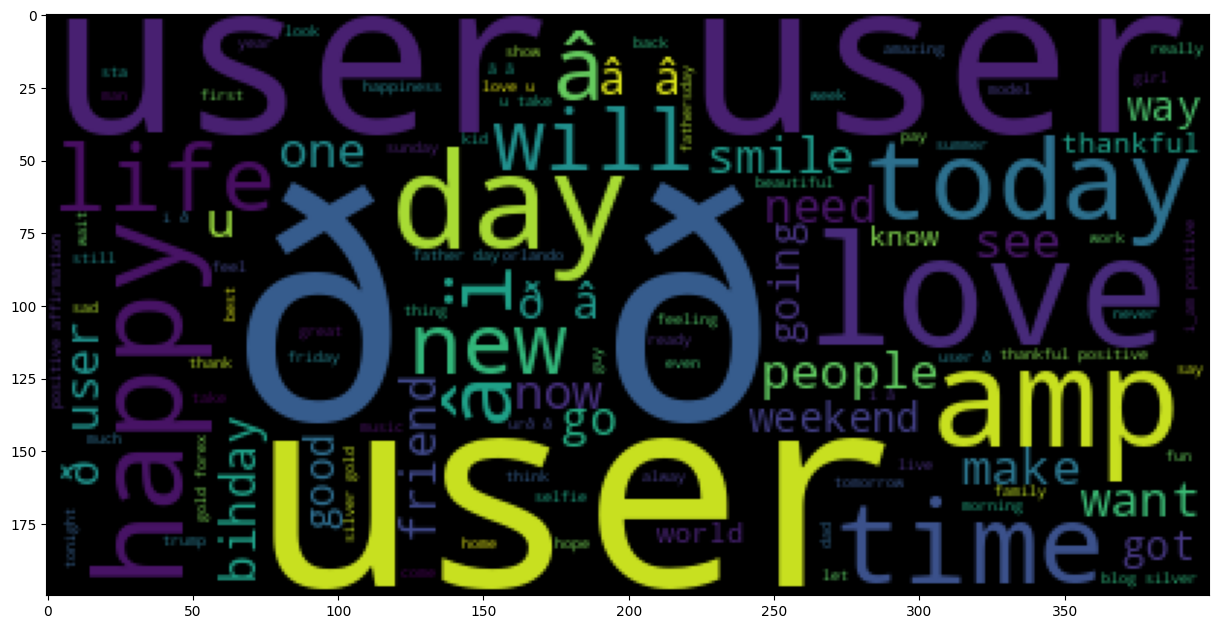

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(sentences_one_string))

## Data Preparation

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df['tweet'], tweets_df['label'], test_size=0.2, random_state=42)

In [17]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [18]:
X_train_vect

<25569x35978 sparse matrix of type '<class 'numpy.float64'>'
	with 292607 stored elements in Compressed Sparse Row format>

## Classification

### Navie Bayes

In [19]:
NB_classifier = MultinomialNB(alpha=1e-4)
NB_classifier.fit(X_train_vect,y_train)

MultinomialNB(alpha=0.0001)

In [20]:
y_pred_test = NB_classifier.predict(X_test_vect)
cm = confusion_matrix(y_test,y_pred_test)
print(cm)


[[5904   33]
 [ 208  248]]


<Axes: >

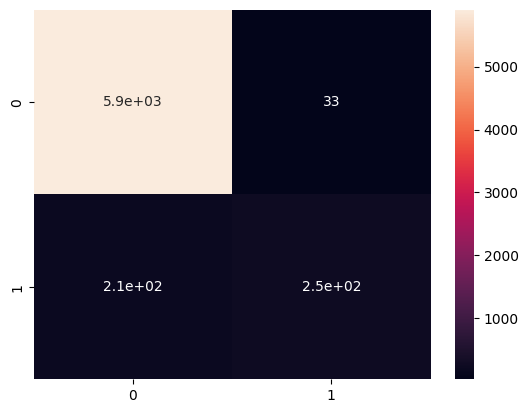

In [21]:
sns.heatmap(cm,annot=True)

In [22]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.88      0.54      0.67       456

    accuracy                           0.96      6393
   macro avg       0.92      0.77      0.83      6393
weighted avg       0.96      0.96      0.96      6393



The overall weighted average is 0.94 for precision, recall, and f1_score. But the f1_score for class 1 is only 0.58. 

In [23]:
auc = roc_auc_score(y_test, y_pred_test)
print(f'AUC Score: {auc}')

AUC Score: 0.7691506431566536


In [24]:
# Identify misclassified observations
def misclassified_observations(y_test,y_pred,X_test):
    misclassified_indices = y_test != y_pred
    misclassified_data = X_test[misclassified_indices]
    misclassified_true_labels = y_test[misclassified_indices]
    misclassified_predictions = y_pred[misclassified_indices]

    # Create a DataFrame to display the misclassified observations
    df_misclassified = pd.DataFrame({
        'Original Text': misclassified_data,
        'True Label': misclassified_true_labels,
        'Predicted Label': misclassified_predictions
    })

    return df_misclassified

In [25]:
misclassified_observations(y_test,y_pred_test,X_test)

,Original Text,True Label,Predicted Label
29841,@user our global media platform would very muc...,0,1
24185,these kind of people need to be erased of eah'...,1,0
25113,history won't forget how barack obama was trea...,1,0
8241,uk 2016: where it fell to pop star @user to do...,1,0
21658,save the date! 1-4-2017 sourcenation! live wed...,1,0
...,...,...,...
13103,@user actually though why have i not gotten co...,0,1
6741,#2017 scatter #joy!â¢ may we bless&amp;keep s...,1,0
25638,@user #stlouis still needs help. @user thinks ...,1,0
7063,@user @user is mexican a language? dude it's o...,1,0


In [26]:
tweets_df.iloc[24185,1]

"these kind of people need to be erased of eah''s surface -_- , "

### XGBoost

In [27]:
wt = (len(y_train)-sum(y_train))/sum(y_train)
wt

13.316349384098544

In [28]:
XGB_classifier = XGBClassifier(scale_pos_weight=11)
XGB_classifier.fit(X_train_vect,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred_test_xgb = XGB_classifier.predict(X_test_vect)
cm_xgb = confusion_matrix(y_test,y_pred_test_xgb)
print(cm_xgb)

[[5623  314]
 [ 136  320]]


<Axes: >

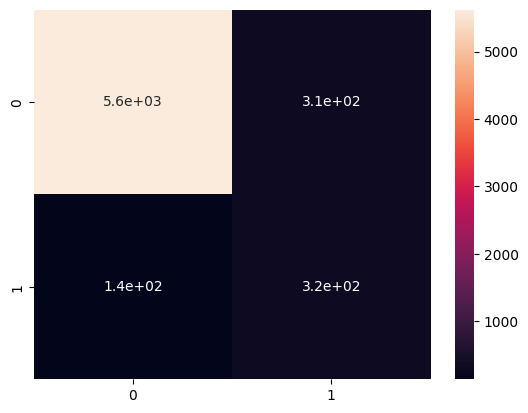

In [30]:
sns.heatmap(cm_xgb,annot=True)

In [31]:
print(classification_report(y_test,y_pred_test_xgb))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5937
           1       0.50      0.70      0.59       456

    accuracy                           0.93      6393
   macro avg       0.74      0.82      0.77      6393
weighted avg       0.94      0.93      0.93      6393



In [32]:
auc = roc_auc_score(y_test, y_pred_test_xgb)
print(f'AUC Score: {auc}')

AUC Score: 0.8244328608281695


In [33]:
misclassified_observations(y_test,y_pred_test_xgb,X_test)

,Original Text,True Label,Predicted Label
27515,"yall animals are cool, but the lack of sympath...",0,1
24185,these kind of people need to be erased of eah'...,1,0
23968,shocked by what's considered racist these days...,0,1
13748,@user you have a lot of company tara. you are ...,0,1
5186,after sex mother porn gallery,0,1
...,...,...,...
6741,#2017 scatter #joy!â¢ may we bless&amp;keep s...,1,0
16324,rough as fuck. #nomakeup #nosoul #nodrugs #no...,0,1
14812,make up #purple #lips #makeup #beauty #willow ...,0,1
25638,@user #stlouis still needs help. @user thinks ...,1,0


In [34]:
X_train_vect.shape

(25569, 35978)

### NN

In [35]:
nn = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='relu',input_shape=(X_train_vect.shape[1],)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2) 
])

In [36]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
nn.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [37]:
nn.fit(X_train_vect, y_train, epochs=5)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9238 - loss: 0.3425
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9615 - loss: 0.1023
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9822 - loss: 0.0537
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9906 - loss: 0.0304
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9958 - loss: 0.0174


In [38]:
y_pred_nn = np.array(tf.argmax(nn.predict(X_test_vect, verbose=2),axis=1))

200/200 - 1s - 3ms/step


In [39]:
cm_nn = confusion_matrix(y_test,y_pred_nn)
print(cm_nn)

[[5853   84]
 [ 171  285]]


<Axes: >

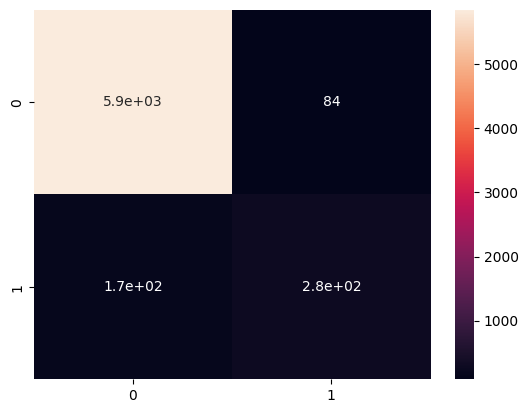

In [40]:
sns.heatmap(cm_nn,annot=True)

In [41]:
print(classification_report(y_test,y_pred_nn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.77      0.62      0.69       456

    accuracy                           0.96      6393
   macro avg       0.87      0.81      0.83      6393
weighted avg       0.96      0.96      0.96      6393



In [42]:
auc = roc_auc_score(y_test, y_pred_nn)
print(f'AUC Score: {auc}')

AUC Score: 0.8054257200606366


In [43]:
misclassified_observations(y_test,y_pred_nn,X_test)

,Original Text,True Label,Predicted Label
24185,these kind of people need to be erased of eah'...,1,0
8241,uk 2016: where it fell to pop star @user to do...,1,0
27616,@user that is what i call serive.,0,1
2265,detroit may have had stronger claim on red win...,0,1
21658,save the date! 1-4-2017 sourcenation! live wed...,1,0
...,...,...,...
23964,churchill guide to public speaking trump wou...,0,1
6741,#2017 scatter #joy!â¢ may we bless&amp;keep s...,1,0
15109,3 years now in kannywood industry acting @us...,0,1
25638,@user #stlouis still needs help. @user thinks ...,1,0


In [44]:
tweets_df.iloc[7063,1]

"@user @user is mexican a language? dude it's obvious you back trump. he said he loves the uneducated.  #bigot #trumpworld"

In [45]:
tweets_df.iloc[12406,1]

'#newyear! new #prez. new #destruction. new #commercials. new !new order! new tweets. new #poopin. new kids on the block. new #america'

In [46]:
tweets_df.iloc[15109,1]

'3 years now in kannywood industry   acting @user @user '

## Conclusion

We explored different classification techniques—Naive Bayes, XGBoost, and neural networks—for Twitter sentiment analysis. Each model demonstrated its strengths in classifying sentiment, with neural networks and XGBoost showing superior performance compared to Naive Bayes. However, we encountered challenges with certain tweets that were difficult to classify accurately, introducing noise into the training process. This noise likely affected the overall performance of the models, highlighting the complexity and nuance inherent in sentiment analysis tasks. Future work may benefit from refining data preprocessing techniques, employing advanced noise reduction methods, and leveraging ensemble approaches to further enhance model robustness and accuracy in sentiment classification.